In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns

# Load MAVE-NN
import sys
path_to_mavenn = '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_git_ssh/'
sys.path.insert(0, path_to_mavenn)
import mavenn

# Other
import logomaker
from scipy.stats import norm
from matplotlib.colors import TwoSlopeNorm, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

In [2]:
mavenn.__path__

['/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_git_ssh/mavenn']

In [3]:
style_file_name = 'fig5.style'
s = """
axes.linewidth:     0.5     # edge linewidth
font.size:          7.0
axes.labelsize:     7.0  # fontsize of the x any y labels
axes.titlesize:     7.0
xtick.labelsize:    7.0  # fontsize of the tick labels
ytick.labelsize:    7.0  # fontsize of the tick labels
legend.fontsize:      7.0
legend.borderpad:     0.2  # border whitespace
legend.labelspacing:  0.2  # the vertical space between the legend entries
legend.borderaxespad: 0.2  # the border between the axes and legend edge
legend.framealpha:    1.0 
lines.dash_capstyle:   round        # {butt, round, projecting}
lines.solid_capstyle:   round        # {butt, round, projecting}
"""
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)

In [4]:
# Load trained models
models = {}
models['additive'] = mavenn.load('fig5_models/mpsa_ge_additive', verbose=False)
models['neighbor']= mavenn.load('fig5_models/mpsa_ge_neighbor', verbose=False)
models['pairwise'] = mavenn.load('fig5_models/mpsa_ge_pairwise', verbose=False)
models['blackbox'] = mavenn.load('fig5_models/mpsa_ge_blackbox', verbose=False)

In [5]:
# Download mpsa dataset from master branch
url = 'https://github.com/jbkinney/mavenn/blob/master/mavenn/examples/datasets/mpsa_data.csv.gz?raw=true'

data_df = pd.read_csv(url,  
                      compression='gzip',
                      index_col=[0])

data_df = data_df.reset_index().copy()

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head(10)

# Get test_df x and y values
x_test = test_df['x'].values
y_test = test_df['y'].values

test N: 6,249
training + validation N: 24,234


In [6]:
# Creat dict to hold information values
info_dict = {}
info_dict['additive\n(epistasis package)','$I_{\\rm var}$'] = {'I':0.000000,'dI':0.000000}
info_dict['additive\n(epistasis package)','$I_{\\rm pred}$'] = {'I':0.220371,'dI':0.012467}

for model_name,model in models.items():
    
    # Compute likelihood information
    I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
    
    # Compute predictive information
    I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
    
    # Add to info_dict
    info_dict[model_name,'$I_{\\rm var}$']  = {'I':I_var,'dI':dI_var}
    info_dict[model_name,'$I_{\\rm pred}$'] = {'I':I_pred,'dI':dI_pred} 

# Transform info_dict into info_df
info_df = pd.DataFrame(info_dict).T
info_df = info_df[['I','dI']].reset_index().copy()
info_df.rename(columns={'level_0':'name'}, inplace=True)
info_df.loc[8:10,'name'] = 'black box'
info_df

,name,level_1,I,dI
0,additive\n(epistasis package),$I_{\rm var}$,0.000000,0.000000
1,additive\n(epistasis package),$I_{\rm pred}$,0.220371,0.012467
2,additive,$I_{\rm var}$,0.198476,0.024130
3,additive,$I_{\rm pred}$,0.273907,0.010316
4,neighbor,$I_{\rm var}$,0.328631,0.032402
5,neighbor,$I_{\rm pred}$,0.342085,0.008330
6,pairwise,$I_{\rm var}$,0.310138,0.022052
7,pairwise,$I_{\rm pred}$,0.382074,0.015541
8,black box,$I_{\rm var}$,0.422644,0.026040
9,black box,$I_{\rm pred}$,0.458969,0.016129


In [7]:
# I_intrinsic bound computed from replicates
I_rep = 0.46067406

In [8]:
# Load results of Sailer-Harms inference
fig5npz = np.load('fig5_SH_data/fig5_data_dict.npz')
phi_sh = fig5npz['phi_sh']
yhat_sh = fig5npz['yhat_sh']
y_sh = fig5npz['y_sh']
phi_grid_sh=fig5npz['phi_grid_sh']
yhat_grid_sh = fig5npz['yhat_grid_sh']

I_epistasis: 0.22037 +- 0.01247 bits
I_mavenn: 0.27391 +- 0.01032 bits
z: 3.31
p-value: 0.0005


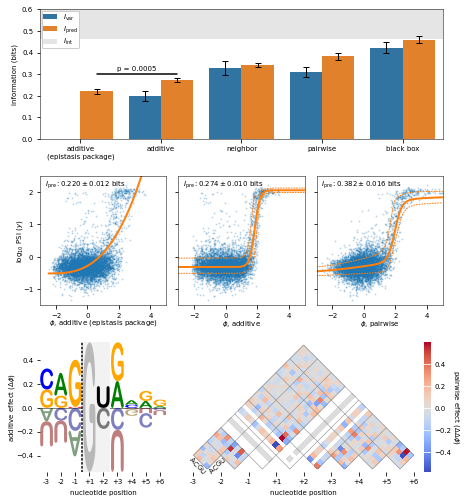

In [9]:
# Create figure
fig = plt.figure(figsize=[6.5, 7])
gs = gridspec.GridSpec(3, 3, figure=fig)


# Set lims and ticks
ylim = [-2.5, 2.5]
yticks = [-6,-4,-2,0,2,4]
philim = [-3,5]
phiticks = [-2,0,2,4]

#
# Panel A: Bar chart
#
ax = fig.add_subplot(gs[0,:])

# Plot I_int region
K = len(info_df)
xlim = [-.5, 4.5]
ylim = [0, 0.6]
ax.fill_between(xlim, [I_rep, I_rep], [.6, .6], color='gray', alpha=.2, zorder=-100, linewidth=0,
                label='$I_\mathrm{int}$')

# Plot bars
sns.barplot(ax=ax, data=info_df, hue='level_1', x='name', y='I')

# Plot 95% confidence intervals
x = np.array([[x-.2,x+.2] for x in range(5)]).ravel()
yerr = info_df['dI'].values
y = info_df['I'].values 
ax.errorbar(x=x[1:], y=y[1:], yerr=yerr[1:], color='k', capsize=3, linestyle='none', 
            elinewidth=1, capthick=1, solid_capstyle='round')
ax.set_ylabel('information (bits)')
ax.set_xlabel('')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Reorder legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[2], handles[0]]
labels = [labels[1], labels[2], labels[0]]
ax.legend(handles, labels, loc='upper left')

# Compute a p-value for additive epistasis vs. MAVE-NN I_pred
I_epistasis = info_df.loc[1,'I']
dI_epistasis = info_df.loc[1,'dI']
print(f'I_epistasis: {I_epistasis:.5f} +- {dI_epistasis:.5f} bits')
I_mavenn = info_df.loc[3,'I']
dI_mavenn = info_df.loc[3,'dI']
print(f'I_mavenn: {I_mavenn:.5f} +- {dI_mavenn:.5f} bits')
z = (I_mavenn - I_epistasis)/np.sqrt(dI_epistasis**2 + dI_mavenn**2)
print(f'z: {z:.2f}')
dist = norm()
p = norm.cdf(-z)
print(f'p-value: {p:.4f}')

# Plot significance line
ax.plot([0.2, 1.2], [.3, .3], '-k')

# Plot text 
ax.text(x=.7, y=.31, s=f'p = {p:.4f}', ha='center', va='bottom')


#
# Panel B: GE plot for Sailer & Harms model
#

ylim = [-1.5, 2.5]
yticks = [-1, 0, 1, 2]

# Show results from Sailer & Harms
# Set ax
ax = fig.add_subplot(gs[1,0])

ax.scatter(phi_sh, 
           y_sh, 
           s=1,
           alpha=.2,
           color='C0')

ax.plot(phi_grid_sh, 
        yhat_grid_sh, 
        color='C1', 
        alpha=1, 
        linestyle='-', 
        linewidth=2, 
        label='$\hat{y}$')

# Style plot
ax.set_xlim(philim)
ax.set_ylim(ylim)
ax.set_yticks(yticks)
ax.set_xlabel(f'$\phi$, additive (epistasis package)', labelpad=-1)
ax.set_ylabel('$\log_{10}$ PSI ($y$)', labelpad=-2)

# Show predictive information
ax.text(x=-2.7, y=2.4, fontsize=7, ha='left', va='top',
        s=f'$I_\mathrm{{pre}}: {I_epistasis:.3f}\pm{dI_epistasis:.3f}$ bits');

#
# Panel C,D: GE plots for MAVE-NN models
#

# Choose phi grid for plotting curves
for i, name in enumerate(['additive', 'pairwise']):
    
    # Set ax
    ax = fig.add_subplot(gs[1,i+1])
    mpsa_model = models[name]
    phi = mpsa_model.x_to_phi(x_test)
    
    phi_grid = np.linspace(philim[0], philim[1], 1000)
    yhat_grid = mpsa_model.phi_to_yhat(phi_grid)
    yqs_grid = mpsa_model.yhat_to_yq(yhat_grid, q=[.16,.84])
    I_pred = info_df[info_df['name']==name].reset_index(drop=True)['I'][1]
    dI_pred = info_df[info_df['name']==name].reset_index(drop=True)['dI'][1]

    # Draw scatter plot
    ax.scatter(phi, 
               y_test, 
               s=1,
               alpha=.2,
               color='C0')

    # Draw GE curve & confidence intervals
    ax.plot(phi_grid, 
            yhat_grid, 
            color='C1', 
            alpha=1, 
            linestyle='-', 
            linewidth=2, 
            label='$\hat{y}$')
    ax.plot(phi_grid, 
            yqs_grid[:,0], 
            color='C1', 
            alpha=1, 
            linestyle=':', 
            linewidth=1, 
            label='95% CI')
    ax.plot(phi_grid, 
            yqs_grid[:,1], 
            color='C1', 
            alpha=1, 
            linestyle=':', 
            linewidth=1)
    
    # Show predictive information
    ax.text(x=-2.7, y=2.4, fontsize=7, ha='left', va='top',
        s=f'$I_\mathrm{{pre}}: {I_pred:.3f}\pm{dI_pred:.3f}$ bits');
    
    # Style plot
    ax.set_xlim(philim)
    ax.set_ylim(ylim)
    ax.set_yticks(yticks)
    ax.set_yticklabels([])
    ax.set_xlabel(f'$\phi$, {name}', labelpad=0)

#
# Panel E: Logo
#   

# Make axes
ax = fig.add_subplot(gs[2,0])

# Draw logo
logo_df = models['pairwise'].get_theta()['logomaker_df'].fillna(0)
logo = logomaker.Logo(df=logo_df, ax=ax, fade_below=.5, shade_below=.5, width=.9, font_name='Arial Rounded MT Bold')

# Style logo
ylim = ax.get_ylim()
logo.highlight_position_range(pmin=3, pmax=4, color='w', alpha=1, zorder=10)
logo.highlight_position_range(pmin=3, pmax=4, color='gray', alpha=.1, zorder=11)
logo.style_single_glyph(p=3, c='G', floor=ylim[0], ceiling=ylim[1], color='gray', zorder=30, alpha=.5)
logo.style_single_glyph(p=4, c='U', color='k', zorder=30)
logo.style_single_glyph(p=4, c='C', color='k', zorder=30)
logo.style_spines(visible=False)

# Sytle axes
ax.axvline(2.5, linestyle=':', color='k', zorder=30)
ax.set_ylabel('additive effect ($\Delta \phi$)', labelpad=-1)
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels([f'{x:+d}' for x in range(-3,7) if x!=0])
ax.set_xlabel('nucleotide position', labelpad=5)

#
# Panel E: Pairwise heatmap
#  

# Make axes
ax = fig.add_subplot(gs[2,-2:])

# Draw heatmap
theta = models['pairwise'].get_theta()['theta_lclc']
ax, cb = mavenn.heatmap_pairwise(values=theta,
                          alphabet='rna',
                          ax=ax,
                          gpmap_type='pairwise',
                          cmap_size='3%')

# Style axes
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels([f'{x:+d}' for x in range(-3,7) if x!=0])
ax.set_xlabel('nucleotide position', labelpad=5)
cb.set_label('pairwise effect ($\Delta \Delta \phi$)', labelpad=5, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=10, color='white')

# Clean tighten layout and save
fig.tight_layout(h_pad=2)
fig.savefig('png/fig5_ipynb.png',dpi=400,facecolor='w')